# Setup

In [1]:
# python standard
import os

# third party
import numpy as np
import pandas as pd
import seaborn as sns
import tzlocal
from pylab import rcParams
from matplotlib import pyplot
%matplotlib inline
import rpy2.robjects as robjects

%load_ext rpy2.ipython

In [2]:
rcParams['figure.figsize'] = 22, 7
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['axes.formatter.useoffset'] = False

# Files/paths
# msg_data_path = '/n/holylfs/LABS/hoekstra_lab/hoekstrafs3/bendesky/genotyping/msg/'
# lib_path = '/n/holylfs/LABS/hoekstra_lab/hoekstrafs3/bendesky/genotyping/physical_map/lib'

# msg_run = os.path.join(msg_data_path, '20151111')
# combine_dir = os.path.join(msg_run, 'combine-difffac_0.1')
# rqtl_dir = os.path.join(msg_run, 'rqtl', 'EPM')

# # Files for rqtl
# cross_path = os.path.join(rqtl_dir, 'cross_EPM_newChromNames_2017.RData')
# # Files for read.cross.msg
# read_cross_file1 = os.path.join(combine_dir, 'ancestry-probs-par2.tsv.sorted.csv')
# read_cross_file2 = os.path.join(combine_dir, 'ancestry-probs-par2.tsv.sorted.pulled.converted.thinned.f2_rqtl')
# EPM_pheno_file = '/n/holylfs/LABS/hoekstra_lab/hoekstrafs3/EPM/results/rqtl_epm_pheno_file.csv'
# ancfile_par1 = os.path.join(combine_dir, 'ancestry-probs-par1.tsv.sorted.pulled.converted.thinned.f2_rqtl')

cross_path = 'cross_EPM_newChromNames_2017.RData'

# Libraries
# r_package_path = os.path.join(lib_path, 'Rpackages')

# Import R Data

In [3]:
%%R
# To load qtl you must have the qtl library installed in R
library(qtl)

In [4]:
%%R -i cross_path
load(cross_path)

In [5]:
%%R
# Current Phenotypes
print(names(cross$pheno))

 [1] "id"                      "sex"                    
 [3] "frac_in_closedAndMiddle" "frac_in_closedArms"     
 [5] "frac_in_middle"          "frac_in_openArms"       
 [7] "entries_to_closed"       "entries_to_open"        
 [9] "distance_in_closed"      "distance_in_open"       
[11] "speed_in_closed"         "speed_in_open"          
[13] "entries_o_c_ratio"       "distance_o_c_ratio"     
[15] "speed_o_c_ratio"         "total_frames"           
[17] "tested_more_than_once"   "pgm"                    
[19] "frac_entries_to_open"    "frac_distance_in_open"  
[21] "log_temp_pheno"         


# Merge R Data with New Features

In [6]:
# Import original data into python
miceDF = robjects.r('cross$pheno')
miceDF = robjects.pandas2ri.ri2py_dataframe(miceDF)

#extract ids
def extractNumber(mouseIDString):
    indexStart = 5
    indexEnd = mouseIDString.find('_')
    return mouseIDString[indexStart:indexEnd]

miceDF['mouseID'] = miceDF['id'].apply(lambda mouseIDString: extractNumber(mouseIDString))

# import new features
newFeaturesPath = 'all_the_data.csv'
newFeaturesDF = pd.read_csv(newFeaturesPath, index_col=0)
newFeaturesDF.set_index('mouse_details_mouseID', inplace=False)

# Drop duplicate mouse IDs in new features
newFeaturesDF = newFeaturesDF.drop_duplicates(subset='mouse_details_mouseID')

newFeaturesDF=newFeaturesDF.rename(columns = {'fraction_in_arms_open-arms':'fraction_in_arms_open'})

# merge new features into previous features
mergedDF = pd.merge(
    miceDF, 
    newFeaturesDF, 
    left_on='mouseID', 
    right_on='mouse_details_mouseID',
    how='left'
)

cross_R_DF = robjects.pandas2ri.py2ri(mergedDF)

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "id". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "sex". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "frac_in_closedAnd

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "total_distance_open". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "turning_preferences_fraction_back". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "turning_preferences_fraction_back_into_closed". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2

In [7]:
goodFeatures = [
    'fraction_in_arms_closed',
    'fraction_in_arms_middle',
    'fraction_in_arms_open',
    'mouse_dimensions_mouseLength',
    'peeking_fraction_total',
    'rest_fraction_all_arms',
    'rest_fraction_closed_arms',
    'rest_fraction_open_arms',
    'safety_fraction_closed_arms',
    'turning_preferences_fraction_back',
    'turning_preferences_fraction_left',
    'turning_preferences_fraction_right',
    'turning_preferences_fraction_straight',
    'velocity_closed_towards_outside_average_speed_active',
    'velocity_open_towards_middle_average_speed_active',
    'velocity_open_towards_outside_average_speed_active'
]

In [8]:
# features that are normally distributed
normal = [
    'fraction_in_arms_closed',
    'fraction_in_arms_middle',
    'fraction_in_arms_open',
    'mouse_dimensions_mouseLength',
    'rest_fraction_all_arms',
    'rest_fraction_closed_arms',
    'rest_fraction_open_arms',
    'turning_preferences_fraction_left',
    'turning_preferences_fraction_right',
    'turning_preferences_fraction_straight',
    'velocity_closed_towards_outside_average_speed_active',
    'safety_fraction_closed_arms']

# features that become normally distributed after log transformation
normalWithLog = ['peeking_fraction_total',
                 'turning_preferences_fraction_back',
                 'velocity_closed_towards_middle_average_speed_active']

# features not normally distributed with any transformation
notNormal = ['peeking_average_length_total',
             'velocity_open_towards_middle_average_speed_active',
             'velocity_open_towards_outside_average_speed_active']

In [9]:
%%R -i goodFeatures,normalWithLog,notNormal,cross_R_DF

goodFeatures <- goodFeatures
normalWithLog <- normalWithLog
notNormal <- notNormal

for (feature in goodFeatures){
    cross$pheno[,feature] <- as.numeric(cross_R_DF[,feature])
}

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [10]:
%%R 
print(summary(cross))

    F2 intercross

    No. individuals:    1571 

    No. phenotypes:     37 
    Percent phenotyped: 80.4 

    No. chromosomes:    24 
        Autosomes:      1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 
                        23 
        X chr:          X 

    Total markers:      51739 
    No. markers:        3680 2706 3346 3181 3273 2538 2402 2543 2012 1806 2183 
                        1950 1134 1704 1529 1786 938 1543 1309 1853 2228 1588 
                        1647 2860 
    Percent genotyped:  99.1 
    Genotypes (%):    
          Autosomes:        AA:23.6      AB:51.6      BB:24.8  not BB:0.0  
                        not AA:0.0  
       X chromosome:        AA:21.3     ABf:19.7     ABr:6.2       BB:0.4  
                            AY:24.1      BY:28.3 


## QTL scans to see if sex makes significant impact on QTL

#### Plot results of scans with sex just as additive covariate

In [11]:
%%R -w 1024 -h 512
#sex <- as.numeric(pull.pheno(cross, "sex") == "M")

for (feature in goodFeatures) {
    if (feature %in% normalWithLog) {
        # Replace 0's in phenotype with the minimum observed for that phenotype before taking the log
        temp_pheno <- cross$pheno[[feature]]
        smallest <- min(temp_pheno[which(temp_pheno>0)])
        temp_pheno[temp_pheno==0] <- smallest
        cross$pheno$log_temp_pheno <- log(temp_pheno)

        out.n <- scanone(cross, pheno="log_temp_pheno", model="normal", method="hk")
        out.a <- scanone(cross, pheno="log_temp_pheno", model="normal", method="hk", addcovar=sex)
        png(paste('Species_and_Sexes_results/', feature, '_addonly.png', sep=""), width=1024)
        main <- bquote(.(feature) ~ ": normal hk log, black=no sex, red=sex as an additive model")
        }
    else if (feature %in% notNormal) {
        # if the feature is not normal with any transformation,
        # use nqrank which transform the feature to the corresponding normal quantiles (preserving the mean and SD)
        out.n <- scanone(cross, pheno=nqrank(cross$pheno[[feature]]), model="normal", method="hk")
        out.a <- scanone(cross, pheno=nqrank(cross$pheno[[feature]]), model="normal", method="hk", addcovar=sex)
        png(paste('Species_and_Sexes_results/', feature, '_addonly.png', sep=""), width=1024)
        main <- bquote(.(feature) ~ ": normal hk nqrank, black=no sex, red=sex as an additive model")
    }
    else {
        out.n <- scanone(cross, pheno=feature, model="normal", method="hk")
        out.a <- scanone(cross, pheno=feature, model="normal", method="hk", addcovar=sex)
        png(paste('Species_and_Sexes_results/', feature, '_addonly.png', sep=""), width=1024)
        main <- bquote(.(feature) ~ ": normal hk, black=no sex, red=sex as an additive model")
    }
    
    plot(out.n, out.a,
         main=main,
         col=c("black", "red"),
         incl.markers=FALSE,
         bandcol='gray90',
         gap=50000000,
         lty=1)

    # Plot thresholds
    #thresh <- 4
    #abline(h=thresh, lty=2, col="dimgray")
    
    cat(feature, ": \n")
    #format="allpeaks" displays the maximum LOD score or each column, with the position at which each was maximized.
    print(summary(out.a, threshold=4, format="allpeaks"))
    cat("\n")

    dev.off()
}

fraction_in_arms_closed : 
            chr      pos  lod
1:120219293   1 1.20e+08 4.83
3:144618317   3 1.45e+08 4.06
4:17486452    4 1.75e+07 5.32

fraction_in_arms_middle : 
            chr      pos  lod
1:100368846   1 1.00e+08 5.21
3:144681235   3 1.45e+08 4.36
9:124322671   9 1.24e+08 4.51
8a:85005756  16 8.50e+07 4.46

fraction_in_arms_open : 
           chr      pos  lod
4:17486452   4 17486452 6.52

mouse_dimensions_mouseLength : 
            chr      pos  lod
14:52350407  14 5.24e+07 7.39
X:103329936   X 1.03e+08 4.57

peeking_fraction_total : 
             chr      pos  lod
17:116670795  17 1.17e+08 4.29

rest_fraction_all_arms : 
            chr      pos  lod
6:29740       6    29740 4.67
10:36593534  10 36593534 4.17
8a:64546974  16 64546974 5.80

rest_fraction_closed_arms : 
            chr      pos  lod
10:36612953  10 36612953 4.78
8a:66419995  16 66419995 5.91

rest_fraction_open_arms : 
            chr      pos  lod
11:24721228  11 24721228 5.13
19:31024377  19 31024377

#### QTL scans of males and females combined, using sex as an interactive covariate to detect QTL that have different effects on the two sexes.

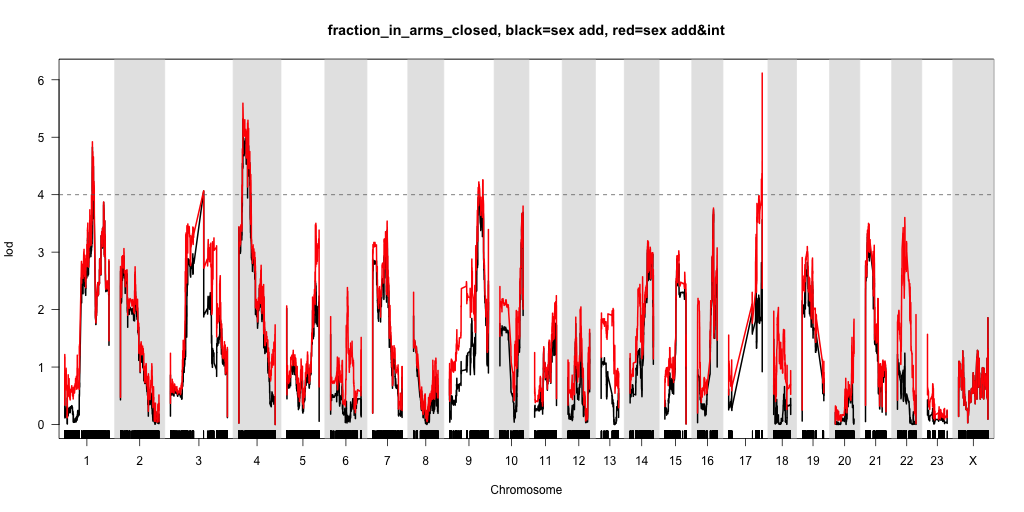

In [12]:
%%R -w 1024 -h 512
sex <- as.numeric(pull.pheno(cross, "sex") == "M")
out.a <- scanone(cross, pheno='fraction_in_arms_closed', model='normal',method='hk', addcovar=sex)
out.i <- scanone(cross, pheno='fraction_in_arms_closed', model="normal", method="hk", addcovar=sex, intcovar=sex)
plot(out.a, out.i,
     bandcol = "gray90",
     col=c('black','red'),
     main="fraction_in_arms_closed, black=sex add, red=sex add&int",
     gap=50000000,
     lty=1)

# Plot thresholds
thresh <- 4
abline(h=thresh, lty=2, col="dimgray")        

In [13]:
%%R -w 1024 -h 512
sex <- as.numeric(pull.pheno(cross, "sex") == "M")
for (feature in goodFeatures) {
    if (feature %in% normalWithLog) {
        # Replace 0's in phenotype with the minimum observed for that phenotype before taking the log
        temp_pheno <- cross$pheno[[feature]]
        smallest <- min(temp_pheno[which(temp_pheno>0)])
        temp_pheno[temp_pheno==0] <- smallest
        cross$pheno$log_temp_pheno <- log(temp_pheno)

        out.a <- scanone(cross, pheno="log_temp_pheno", model="normal", method="hk", addcovar=sex)
        out.i <- scanone(cross, pheno="log_temp_pheno", model="normal", method="hk", addcovar=sex, intcovar=sex)
        png(paste('Species_and_Sexes_results/', feature, '.png', sep=""), width=1024)
        main <- bquote(.(feature) ~ ": normal hk log, sex as an interactive model, difference between models")
    }
    else if (feature %in% notNormal) {
        # if the feature is not normal with any transformation,
        # use nqrank which transform the feature to the corresponding normal quantiles (preserving the mean and SD)
        out.a <- scanone(cross, pheno=nqrank(cross$pheno[[feature]]), model="normal", method="hk", addcovar=sex)
        out.i <- scanone(cross, pheno=nqrank(cross$pheno[[feature]]), model="normal", method="hk", addcovar=sex, intcovar=sex)
        png(paste('Species_and_Sexes_results/', feature, '.png', sep=""), width=1024)
        main <- bquote(.(feature) ~ ": normal hk nqrank, sex as an interactive model, difference between models")
    }
    else {
        out.a <- scanone(cross, pheno=feature, model="normal", method="hk", addcovar=sex)
        out.i <- scanone(cross, pheno=feature, model="normal", method="hk", addcovar=sex, intcovar=sex)
        png(paste('Species_and_Sexes_results/', feature, '.png', sep=""), width=1024)
        main <- bquote(.(feature) ~ ": normal hk, sex as an interactive model, difference between models")
    }
        
    plot(out.i-out.a,
         main=main,
         col=c("black"),
         incl.markers=FALSE,
         bandcol='gray90',
         gap=50000000,
         lty=1)

    cat(feature, ": \n")
    print(summary(out.i-out.a, format="allpeaks"))
    cat("\n")
    
    dev.off()
}

fraction_in_arms_closed : 
               chr      pos   lod
1:54466722       1 5.45e+07 1.036
2:136590046      2 1.37e+08 0.744
3:200728724      3 2.01e+08 2.154
4:157837807      4 1.58e+08 1.257
5:127070759      5 1.27e+08 1.243
6:72917083       6 7.29e+07 2.289
7:110483304      7 1.10e+08 0.462
8b:106197312     8 1.06e+08 0.586
9:72766202       9 7.28e+07 1.452
10:71627308     10 7.16e+07 1.739
11:12363        11 1.24e+04 1.105
12:3431666      12 3.43e+06 0.801
13:52734389     13 5.27e+07 1.711
14:42526247     14 4.25e+07 1.235
15:7205206      15 7.21e+06 0.825
8a:1948052      16 1.95e+06 1.327
17:145875708    17 1.46e+08 2.773
18:20460942     18 2.05e+07 1.886
19:73682        19 7.37e+04 0.752
20:81187290     20 8.12e+07 1.786
16-21:12520679  21 1.25e+07 0.806
22:39337105     22 3.93e+07 2.671
23:22506376     23 2.25e+07 1.340
X:63390082       X 6.34e+07 0.000

fraction_in_arms_middle : 
                chr      pos   lod
1:43494           1 4.35e+04 0.872
2:138425679       2 1.38e